In [ ]:
# Clone repo
!git clone https://github.com/Danfoa/slip_control.git
# Move to repo folder
!cd slip_control
# Use pip to install repo and dependencies


fatal: destination path 'slip_control' already exists and is not an empty directory.
Processing ./slip_control
  Preparing metadata (setup.py) ... done
  Created wheel for slip-control: filename=slip_control-0.0.1-py3-none-any.whl size=30681 sha256=1392660e925912b0fcd2988745cdd42ae530cdbbdd52471e75897c6c0ef7dae8
  Stored in directory: /tmp/pip-ephem-wheel-cache-0849khsy/wheels/2d/9a/ed/6b5b0b1e16b37e75a122a1ece9db138c3ec11c23e01ba52b35
Successfully built slip-control


In [30]:
!pip install /content/slip_control/

Processing ./slip_control
  Preparing metadata (setup.py) ... done
  Created wheel for slip-control: filename=slip_control-0.0.1-py3-none-any.whl size=32048 sha256=ae8d273f546ea81386bba56c1d250a90827cebe8ce6e88d40c6b42a650d61956
  Stored in directory: /tmp/pip-ephem-wheel-cache-aj92h273/wheels/2d/9a/ed/6b5b0b1e16b37e75a122a1ece9db138c3ec11c23e01ba52b35
Successfully built slip-control
  Attempting uninstall: slip-control
    Found existing installation: slip-control 0.0.1
    Uninstalling slip-control-0.0.1:
      Successfully uninstalled slip-control-0.0.1


FloatText(value=183.0, description='Height (cm):')

IntText(value=4, description='Number of Cycles:')

Text(value='animation.gif', description='Animation Filename:')

Button(description='Run Simulation', style=ButtonStyle())

Button(description='Save Animation', style=ButtonStyle())

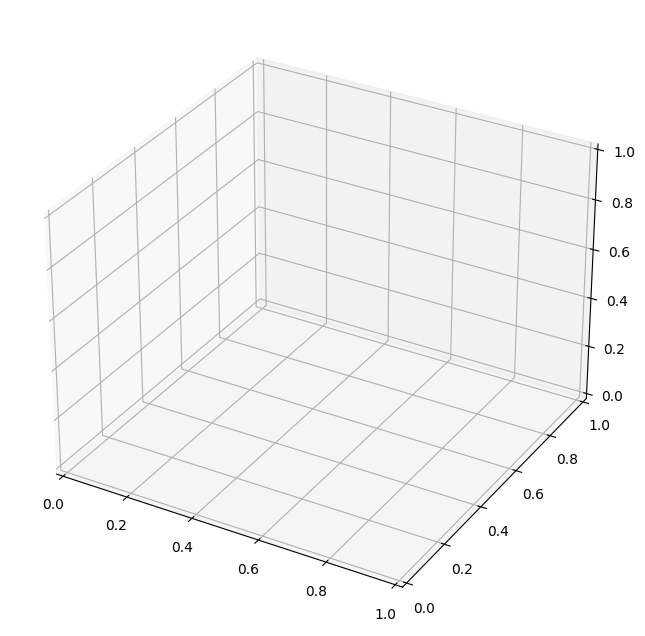

Constructing QP (DCP)
Traj Optimization: 100%|██████████| 4/4.0 [00:07<00:00,  1.80s/it]
Combining optimal cycles into a single trajectory


ValueError: ignored

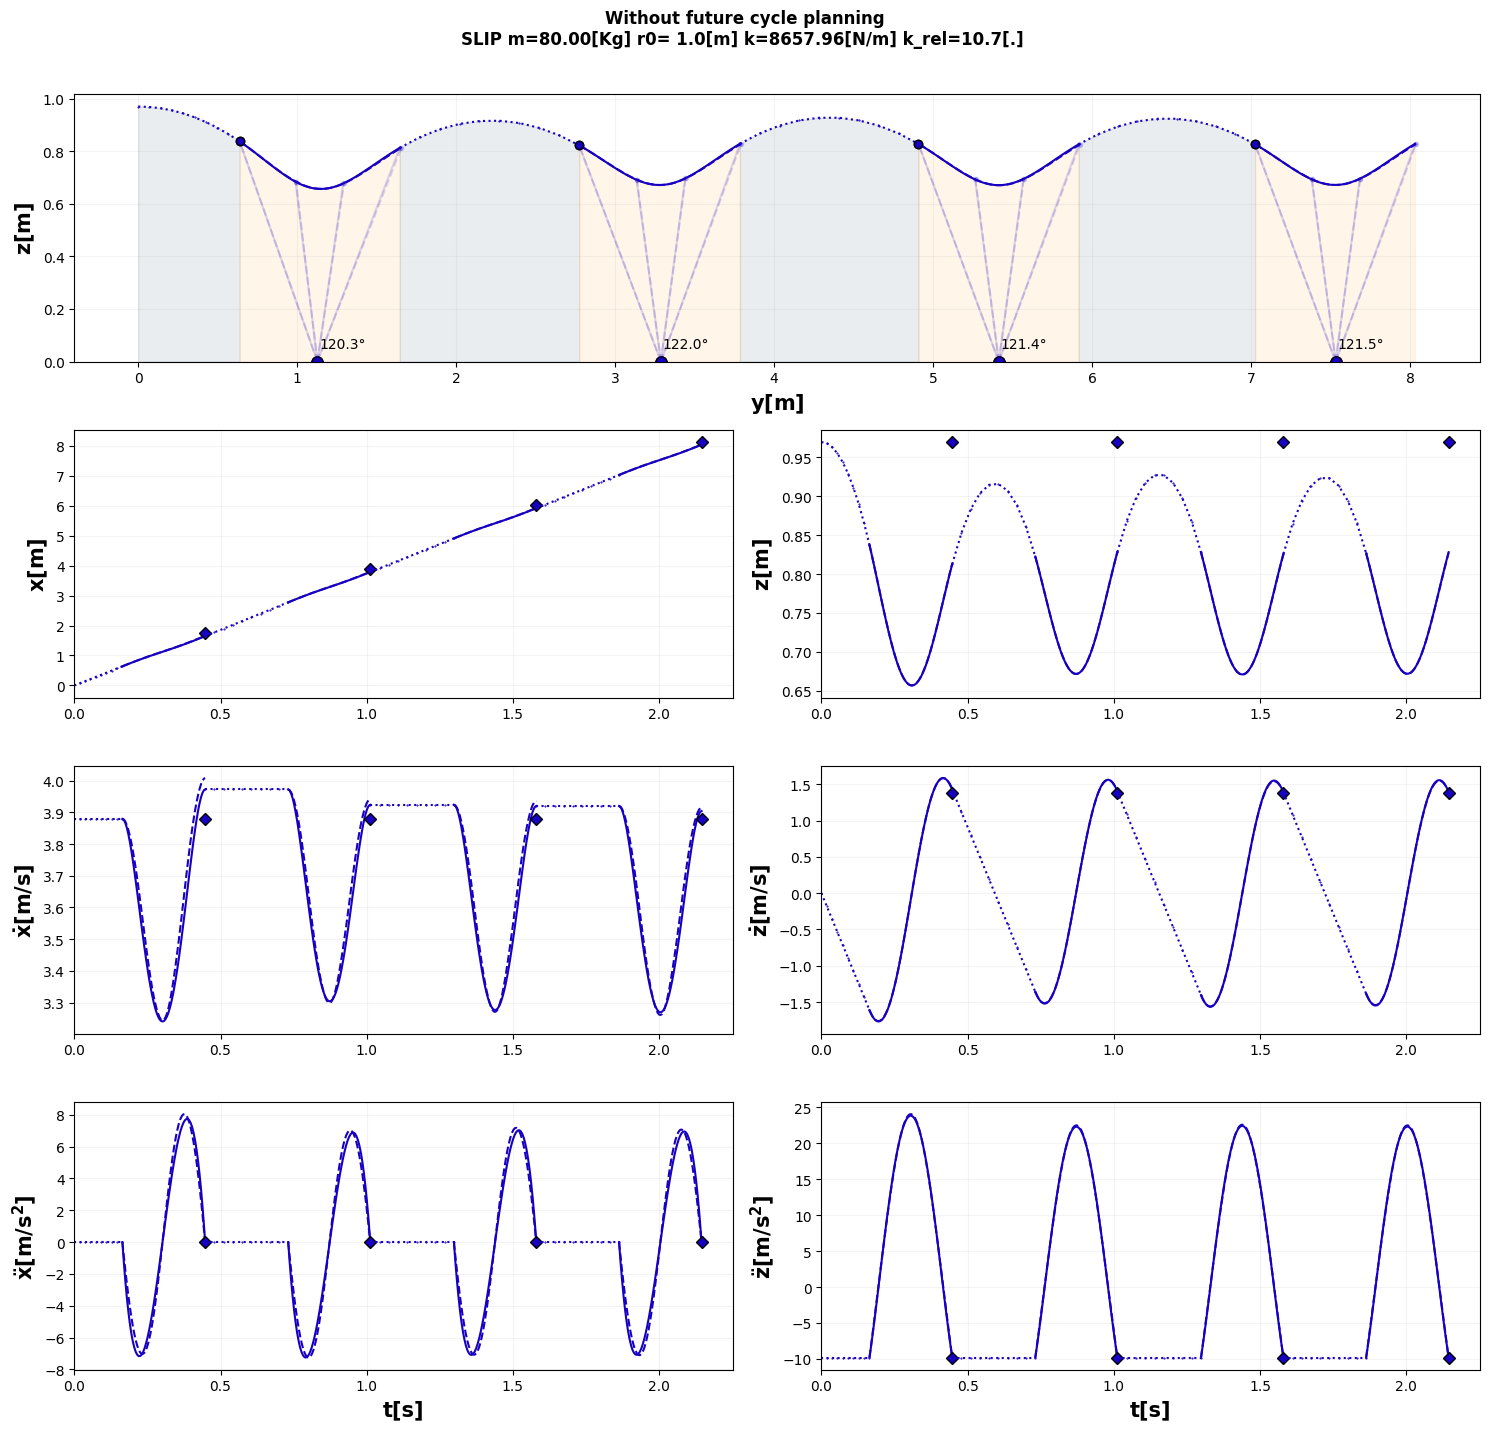

In [6]:
import time
import tkinter as tk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from matplotlib import animation
from math import pi as PI
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy import signal
from argparse import ArgumentParser

from slip_control.slip.slip_trajectory import SlipTrajectory
from slip_control.slip.slip_model import SlipModel, X, X_DOT, X_DDOT, Z, Z_DOT, Z_DDOT
from slip_control.controllers.target_to_states_generator import CycleStateGenerator, ForwardSpeedStateGenerator
from slip_control.controllers.diff_flat_slip_controller import SlipDiffFlatController
from slip_control.utils import plot_utils

def run_simulation(height, cycles,theta_max,torso_width,simulation, filename):
    pelvis_length = torso_width/100
    height = height / 100
    pendulum_length = height*0.53


    def draw_body(body_left,body_right):
        body_dim = height * 0.4
        x = [body_left[0], body_right[0], body_left[0], body_right[0]]
        y = [body_left[1], body_right[1], body_left[1], body_right[1]]
        z = [body_left[2], body_right[2], body_left[2]+body_dim, body_right[2]+body_dim]
        verts = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(verts,linewidth=10,edgecolor="k",facecolor = "red",rasterized=False))
        r = 0.01
        u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:30j]
        x = (body_left[0]+ body_right[0])/2+(np.cos(u) * np.sin(v))*0.4
        y = (body_left[1]+ body_right[1])/2+((np.sin(u) * np.sin(v))*0.06)
        z = body_left[2]+body_dim+.28 + np.cos(v) *0.2
        ax.plot_surface(x, y, z,color='r')

    def draw_line(pos1, pos2):
        for i in range(3):
            xs = [pos1[0], pos2[0]]
            ys = [pos1[1], pos2[1]]
            zs = [pos1[2], pos2[2]]
            # Plot contour curves
            line1, = ax.plot(xs, ys, zs,'k', linewidth=5)
        return line1

    #time.sleep(3) # wait 3 seconds

    def motion_generator(cycles):
        pos_pendulum_left = np.array([0, 0, 0])
        pos_pendulum_right = np.array([0, pelvis_length, 0])
        body_left = np.array([0, 0, pendulum_length])
        body_right = np.array([0, pelvis_length, pendulum_length])
        body_left = np.vstack([body_left, body_left])
        body_right = np.vstack([body_right, body_right])
        pos_pendulum_left = np.vstack([pos_pendulum_left, pos_pendulum_left])
        pos_pendulum_right = np.vstack([pos_pendulum_right, pos_pendulum_right])
        theta_1, theta_2, cycle_definition_left, cycle_definition_right, at_change = motion_planner(cycles)
        pend_prev = [pos_pendulum_right[0], pos_pendulum_left[0]]
        body_prev = [body_right[0], body_left[0]]
        for index , cycle in enumerate(cycle_definition_left):
            if at_change[index]==1:
                pend_prev = [pos_pendulum_right[index],pos_pendulum_left[index]]
            if cycle == 1:
                pos_pendulum_new_left = pend_prev[1]

                body_new_left = [pos_pendulum_new_left[0] + pendulum_length * np.sin(np.deg2rad(theta_1[index])),
                                       0,
                                 pendulum_length *(np.cos(np.deg2rad(theta_2[index]))) ]
                body_new_right = [body_new_left[0],pelvis_length,body_new_left[2]] #[body_prev[0, 0] + pendulum_length * np.sin(np.deg2rad(theta[index])),
                                # body_prev[0, 1],
                                 #pendulum_length * np.cos(np.deg2rad(theta[index]))]
                pos_pendulum_new_right = [body_new_right[0] + pendulum_length * np.sin(np.deg2rad(theta_2[index])),
                                          body_new_right[1],
                                          body_new_right[2] - pendulum_length * np.cos(np.deg2rad(theta_2[index]))]
                body_left = np.vstack([body_left, body_new_left])
                body_right = np.vstack([body_right, body_new_right])
                pos_pendulum_left =  np.vstack([pos_pendulum_left, pos_pendulum_new_left])
                pos_pendulum_right = np.vstack([pos_pendulum_right, pos_pendulum_new_right])
            if cycle == -1:
                pos_pendulum_new_right = pend_prev[0]

                body_new_right = [pos_pendulum_new_right[0] + pendulum_length * np.sin(np.deg2rad(theta_1[index])),
                                 pelvis_length,
                                  pendulum_length *(np.cos(np.deg2rad(theta_1[index])))]
                body_new_left = [body_new_right[0], 0, body_new_right[2]]  # [body_prev[0, 0] + pendulum_length * np.sin(np.deg2rad(theta[index])),
                # body_prev[0, 1],
                # pendulum_length * np.cos(np.deg2rad(theta[index]))]
                pos_pendulum_new_left = [body_new_right[0] + pendulum_length * np.sin(np.deg2rad(theta_1[index])),
                                          0,
                                          body_new_right[2] - pendulum_length * np.cos(np.deg2rad(theta_1[index]))]
                body_left = np.vstack([body_left, body_new_left])
                body_right = np.vstack([body_right, body_new_right])
                pos_pendulum_left = np.vstack([pos_pendulum_left, pos_pendulum_new_left])
                pos_pendulum_right = np.vstack([pos_pendulum_right, pos_pendulum_new_right])




        return pos_pendulum_left, body_left,pos_pendulum_right,body_right,theta_1,theta_2

    def motion_planner(cycles):

        theta_1 = np.linspace(0, theta_max , data_points)
        theta_2 = np.linspace(0,theta_max,  data_points)
        at_change = [0]  * (data_points)
        cycle_definition_left =  [1]  * (data_points)
        cycle_definition_right = [-1]  * (data_points)
        for i in range(1,cycles*2+1):
            if i % 2 ==0:
                theta_1 = np.append(theta_1,np.linspace(-theta_max,theta_max,  data_points))
                theta_2 = np.append(theta_2,np.linspace( -theta_max, theta_max, data_points))
                cycle_definition_left = np.append(cycle_definition_left, [1] * data_points)
                cycle_definition_right = np.append(cycle_definition_right, [-1] * data_points)
                at_change = np.append(at_change,np.append([1], [0] * (data_points-1)))
            else:
                theta_1 = np.append(theta_1, np.linspace(-theta_max, theta_max, data_points))
                theta_2 = np.append(theta_2, np.linspace(-theta_max,theta_max, data_points))
                cycle_definition_left = np.append(cycle_definition_left, [-1] * data_points)
                cycle_definition_right = np.append(cycle_definition_right, [1] * data_points)
                at_change = np.append(at_change, np.append([1], [0] * (data_points-1)))
        return theta_1,theta_2,cycle_definition_left,cycle_definition_right,at_change





    data_points = 20
    pos_pendulum_left, body_left, pos_pendulum_right, body_right,theta_1,theta_2 = motion_generator(cycles)
    def update(frame):
        i = frame
        ax.clear()


        ax.axes.set_xlim3d(left=body_right[i, 0] - 2, right=body_right[i, 0] + 2)
        ax.axes.set_ylim3d(bottom=-.10, top=pelvis_length + .10)
        ax.axes.set_zlim3d(bottom=0, top=height+.20)
        # ax.azim = -90
        # ax.dist = 20
        # ax.elev = 0
        ax.scatter(pos_pendulum_left[i, 0], pos_pendulum_left[i, 1], pos_pendulum_left[i, 2], c='b', marker='o')
        ax.scatter(pos_pendulum_right[i, 0], pos_pendulum_right[i, 1], pos_pendulum_right[0, 2], c='g', marker='o')
        ax.scatter(body_left[i, 0], body_left[i, 1], body_left[i, 2], c='r', marker='o')
        ax.scatter(body_right[i, 0], body_right[i, 1], body_right[i, 2], c='k', marker='o')
        draw_line(pos_pendulum_left[i,:], body_left[i,:])
        draw_line(body_left[i,:], body_right[i,:])
        draw_line(body_right[i,:], pos_pendulum_right[i,:])
        draw_body(body_left[i,:], body_right[i,:])

        ax.set_box_aspect((60, 40, 50))
        ax.set_xlabel('(m)', fontsize=10)
        ax.set_ylabel('(m)', fontsize=10)

        ax.plot(body_right[:i,0],body_right[:i,1],body_right[:i,2], linewidth=.5, dashes=[5, 3], c='k')

        ax.plot(body_left[:i, 0],body_left[:i, 1], body_left[:i, 2], linewidth=.5, dashes=[5, 3], c='r')
        ax.plot(pos_pendulum_right[:i, 0], pos_pendulum_right[:i, 1], pos_pendulum_right[:i, 2], linewidth=.5, dashes=[5, 3], c='g')
        ax.plot(pos_pendulum_left[:i, 0], pos_pendulum_left[:i, 1], pos_pendulum_left[:i, 2], linewidth=.5, dashes=[5, 3], c='b')

    if simulation == 1:
        anim = animation.FuncAnimation(fig, update, frames=100)
        anim.save(filename, writer='imagemagick', fps=30)
    else :
        for i in range(pos_pendulum_left.shape[0]):  # range(len(pos_pendulum_left)):
            update(i)

def slip(height,cycles):
    # Instantiate SLIP model
    height = height / 100
    r0 = height * 0.53
    m = 80  # [kg]
    pelvis_length = 0.021  # int(pelvis_entry.get())
    n_legs = 1
    k_rel = 10.7
    slip = SlipModel(mass=m, leg_length=r0, k_rel=k_rel * n_legs)

    g = SlipModel.g

    # Error deviation weights during the stance trajectory
    traj_weights = np.array([1., 1., 1., 1., 1., 1.])
    traj_weights /= np.linalg.norm(traj_weights)
    # Error deviation weights of target take-off states
    take_off_state_error_weights = np.array([0.0, 1.0, 0., 1.0, 1.0, 0.])
    take_off_state_error_weights /= np.linalg.norm(take_off_state_error_weights)

    n_cycles = cycles  # Generate a trajectory of 5 cycles
    max_theta_dot = 4 * PI  # [rad/s] max angular leg velocity during flight
    # Define a forward velocity
    forward_speed = 4 * slip.r0  # [m/s]
    # Define a desired gait duty cycle (time of stance / time of cycle) in [0.2, 1.0]
    duty_cycle = 0.5

    z_init = slip.r0
    # Set an initial state (assumed to be a flight phase state)  [x, x', x'', z, z', z'']
    init_to_state = np.array([0.0, forward_speed, 0.0, z_init, 0.0, -g])
    # Set a desired take off state defining the forward and vertical velocity desired
    to_des_state = init_to_state

    # Configure Differentially flat controller
    slip_controller = SlipDiffFlatController(slip_model=slip,
                                             traj_weights=traj_weights,
                                             max_flight_theta_dot=max_theta_dot,
                                             debug=False)
    to_state_generator = ForwardSpeedStateGenerator(slip_model=slip, target_state_weights=take_off_state_error_weights,
                                                    desired_forward_speed=forward_speed,
                                                    desired_duty_cycle=duty_cycle)
    slip_controller.target_to_state_generator = to_state_generator

    # Generate SLIP trajectory tree without future cycle planning
    tree = slip_controller.generate_slip_trajectory_tree(desired_gait_cycles=n_cycles,
                                                         initial_state=init_to_state,
                                                         max_samples_per_cycle=30,
                                                         angle_epsilon=np.deg2rad(.02),
                                                         look_ahead_cycles=0)
    slip_traj_no_future = tree.get_optimal_trajectory()
    plt_axs,foot_pos_list,gait_xz , time, time_label=plot_utils.plot_slip_trajectory(slip_traj_no_future, plot_passive=True, plot_td_angles=True, title="Without future cycle planning", color=(23 / 255., 0 / 255., 194 / 255.))
    gait_y = np.zeros(gait_xz[:,0].shape)

    def generate_full_body():

        i_prev = 0
        k = 0
        next_flight = 0
        next_contact = 0
        op_needed = True
        full_body = np.array([0, 0, 0, 0,0,0])
        full_body_left = np.vstack((full_body,full_body))

        for index, i in enumerate(time_label):
            if i != i_prev and k==1:
                next_contact = [x-index for x in np.where(time_label[index:] == 0)][0][0]
                op_needed = False
                k=0
            if i == 0 and op_needed:
                next_flight = [x for x in np.where(time_label[index:] == 1)][0][0]-1
                op_needed = False
                k=1
            i_prev = i
        i_prev = 1
        calculate = 0
        z=0
        for index, i in enumerate(time_label[1:]):
            if i != i_prev:
                calculate = 1
                z=z+1
            if i == 0 and calculate==1:
                body = np.array([gait_xz[index:index + next_flight, 0], gait_y[index:index + next_flight],
                                 gait_xz[index:index + next_flight, 1], foot_pos_list[index:index + next_flight, 0],
                                 gait_y[index:index + next_flight], foot_pos_list[index:index + next_flight, 1]])

                ur = 50
                #body_res=np.empty((int(next_contact)*10,6))
                #for k,a in enumerate(body):
                #    body_reseampled = np.array([np.interp(np.arange((len(a) - 1) * ur) / ur, xp=np.arange(len(a)), fp=a)])
                #    body_res[:,k]=body_reseampled[0]#np.append(body_res,body_reseampled, axis=1)
                full_body_left = np.vstack((full_body_left,body))
                #full_body_right = np.vstack((full_body_right, body_right.T))
                calculate = 0

            if i == 1 and calculate==1:
                body = np.array([gait_xz[index:index + next_contact, 0], gait_y[index:index + next_contact],
                                 gait_xz[index:index + next_contact, 1], foot_pos_list[index:index + next_contact, 0],
                                 gait_y[index:index + next_contact], foot_pos_list[index:index + next_contact, 1]])

                range_1, range_2 = index , index  + next_flight #+ next_flight  # index , index +next_flight

                ur= 40
                body_res=np.empty((int(next_contact),6))
                #for k,a in enumerate(body):
                #    body_reseampled = np.array([np.interp(np.arange((len(a) - 1) * ur ) / ur, xp=np.arange(len(a)), fp=a)])

                #    body_res[:,k]=body_reseampled[0]#np.append(body_res,body_reseampled, axis=1)
                full_body_left = np.vstack((full_body_left, body))
               #full_body_right = np.vstack((full_body_right, body_res))

                calculate = 0

            i_prev = i
        range_1, range_2 = next_contact-1,next_contact
        body_right = np.array([gait_xz[range_1:range_2, 0],
                               gait_y[range_1:range_2]+pelvis_length,
                               gait_xz[range_1:range_2, 1],
                               foot_pos_list[range_1:range_2, 0],
                               gait_y[range_1:range_2]+pelvis_length,
                               foot_pos_list[range_1:range_2, 1]])
        full_body_right = np.vstack((body_right.T, body_right.T))
        for i in range (next_contact):
            full_body_right = np.vstack((full_body_right, full_body_right[-1]))
            full_body_left = np.vstack((full_body_left, full_body_left[-1]))

        next_flight = next_contact
        step_length = np.max(full_body_left[:, 0]) / cycles
        full_body_right_n = np.array([np.array(full_body_left[:-next_flight, 0])+step_length/2,np.array(full_body_left[:-next_flight,1]) + pelvis_length,np.array(full_body_left[:-next_flight, 2]),np.array(full_body_left[:-next_flight, 3])+step_length/2,np.array(full_body_left[:-next_flight,4]) + pelvis_length,full_body_left[:-next_flight, 5]]).T
        full_body_right = np.vstack((full_body_right[:next_flight], full_body_right_n[:-next_flight]))
        print(full_body_left.shape,full_body_right.shape)
        return full_body_left, full_body_right,next_contact
    def draw_body(body_left,body_right):
        body_dim = height * 0.4
        x = [body_left[0], body_right[0], body_left[0], body_right[0]]
        y = [body_left[1], body_right[1], body_left[1], body_right[1]]
        z = [body_left[2], body_right[2], body_left[2]+body_dim, body_right[2]+body_dim]
        verts = [list(zip(x, y, z))]
        ax.add_collection3d(Poly3DCollection(verts,linewidth=20,edgecolor="k",facecolor = "red",rasterized=False))
        r = 0.01
        u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:30j]
        x = (body_left[0]+ body_right[0])/2+(np.cos(u) * np.sin(v))*0.4
        y = (body_left[1]+ body_right[1])/2+((np.sin(u) * np.sin(v))*0.06)
        z = body_left[2]+body_dim+.28 + np.cos(v) *0.2
        ax.plot_surface(x, y, z,color='r')

    def draw_line(pos1, pos2):
        for i in range(3):
            xs = [pos1[0], pos2[0]]
            ys = [pos1[1], pos2[1]]
            zs = [pos1[2], pos2[2]]
            # Plot contour curves
            line1, = ax.plot(xs, ys, zs,'k', linewidth=5)
        return line1
    # fig2, ax2 = plt.subplots()
    # for index, i in enumerate(foot_pos_list):
    #     ax2.plot(*spring(gait_xz[index],foot_pos_list[index],3, 0.5), c="black")
    #     ax2.set_aspect("equal", "box")
    full_body_left, full_body_right , next_contact = generate_full_body()

    def update(frame):
        i = frame
        ax.clear()
        ax.scatter(gait_xz[i, 0],gait_y[i], gait_xz[i, 1], c='b', marker='o')
        ax.scatter(foot_pos_list[i, 0],gait_y[i], foot_pos_list[i, 1], c='r', marker='o')
        ax.plot(gait_xz[:i,0],gait_y[:i],gait_xz[:i,1], linewidth=.5, dashes=[5, 3], c='k')
        ax.axes.set_xlim3d(left=gait_xz[i, 0] - 2, right=gait_xz[i, 0] + 2)
        ax.axes.set_ylim3d(bottom=-.10, top=0.1 + .10)
        ax.axes.set_zlim3d(bottom=0, top=height + .20)
        ax.set_title(f'{round(time[i],2)} sec')
        spring_x,spring_z = spring(gait_xz[i], foot_pos_list[i], 5, 0.3)
        spring_y = np.zeros(spring_x.shape)
        ax.plot(foot_pos_list[:i, 0],gait_y[:i],foot_pos_list[:i, 1], linewidth=.5, dashes=[5, 3], c='r')
        ax.plot(spring_x,spring_y,spring_z, c="black")
        #ax.set_aspect("equal", "box")
    def update2(frame,pelvis_length):
        i = frame
        ax.clear()
        ax.scatter(full_body_left[i, 0],full_body_left[i,1], full_body_left[i, 2], c='b', marker='o')
        ax.scatter(full_body_left[i, 3],full_body_left[i,4], full_body_left[i,5], c='r', marker='o')
        ax.scatter(full_body_right[i, 0], full_body_right[i, 1], full_body_right[i, 2], c='g', marker='o')
        ax.scatter(full_body_right[i, 3], full_body_right[i, 4], full_body_right[i, 5], c='k', marker='o')
        ax.plot(full_body_left[:i, 0],full_body_left[:i,1], full_body_left[:i, 2], linewidth=.5, dashes=[5, 3], c='k')
        ax.plot(full_body_right[:i, 0], full_body_right[:i, 1], full_body_right[:i, 2], linewidth=.5, dashes=[5, 3], c='k')
        #
        ax.axes.set_xlim3d(left=full_body_left[i, 0] - 1, right=full_body_left[i, 0] + 1)
        ax.axes.set_zlim3d(bottom=0, top=height + .20)
        #ax.set_title(f'{round(time[i],2)} sec')
        draw_body(full_body_left[i,0:3], full_body_right[i,0:3])
        # draw_line(body_left[i,:], body_right[i,:])
        # draw_line(body_right[i,:], pos_pendulum_right[i,:])
        # draw_body(body_left[i,:], body_right[i,:])

        ax.set_box_aspect((60, 40, 50))
        ax.set_xlabel('(m)', fontsize=10)
        ax.set_ylabel('(m)', fontsize=10)
        spring_x,spring_z = spring([full_body_left[i, 0], full_body_left[i, 2]], [full_body_left[i, 3], full_body_left[i, 5]], 5, 0.3)
        spring_y = np.zeros(spring_x.shape)
        ax.plot(spring_x,spring_y,spring_z, c="black",linewidth= 5)
        spring_x, spring_z = spring([full_body_right[i, 0], full_body_right[i, 2]],
                                    [full_body_right[i, 3], full_body_right[i, 5]], 5, 0.3)
        spring_y = np.zeros(spring_x.shape)+pelvis_length# full_body_right[20, 1]
        ax.plot(spring_x, spring_y, spring_z, c="black",linewidth= 5)


    for i in range(next_contact+2,full_body_right.shape[0]):
       update2(i,pelvis_length)
    # for i in range(foot_pos_list.shape[0]):  # range(len(pos_pendulum_left)):
    #     update(i)
    plt.show()


import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Function to handle the Run Simulation button click
def run_simulation(b):
    height = float(height_entry.value)
    cycles = int(cycles_entry.value)
    slip(height, cycles)

# Function to save the animation
def save_animation(b):
    filename = animation_entry.value
    height = float(height_entry.value)
    cycles = int(cycles_entry.value)
    # Call your function to save the animation
    # Assuming it modifies the 'fig' variable
    run_simulation(height, cycles, filename)
    fig.savefig(filename)
    display(FileLink(filename))

# Widgets
height_entry = widgets.FloatText(description='Height (cm):', value=183)
cycles_entry = widgets.IntText(description='Number of Cycles:', value=4)
animation_entry = widgets.Text(description='Animation Filename:', value='animation.gif')

run_button = widgets.Button(description='Run Simulation')
run_button.on_click(run_simulation)

save_button = widgets.Button(description='Save Animation')
save_button.on_click(save_animation)

# Displaying Widgets
display(height_entry, cycles_entry, animation_entry, run_button, save_button)

# Plotting area
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')



